In [1]:
# First, downgrade opencv to be compatible with numpy 1.x
!pip install 'opencv-python-headless<4.10' 'numpy>=1.23.5,<2.0'

# Then install cellpose without GUI (since GUI dependencies force numpy 2.x)
!pip install cellpose

# Verify installation
!pip list | grep -E "numpy|cellpose|opencv"

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.6 MB)

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached cellpose-4.0.8-py3-none-any.whl.metadata (22 kB)
  Using cached natsort-8.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached fastremap-1.17.7-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (10 kB)
  Using cached fill_voids-2.1.1-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (6.0 kB)
Using cached cellpose-4.0.8-py3-none-any.whl (212 kB)
Using cached fastremap-1.17.7-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (7.6 MB)
U

In [2]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


Loading Cellpose-SAM model...
  ✓ Model loaded
CELLPOSE-SAM BENCHMARK 1: SINGLE TILE (512×512)
Tile shape: (512, 512, 3)
Warmup runs...
Running 10 timed iterations...
  Run 1/10: 0.179s, 1.49 GB
  Run 2/10: 0.174s, 1.49 GB
  Run 3/10: 0.172s, 1.49 GB
  Run 4/10: 0.172s, 1.49 GB
  Run 5/10: 0.174s, 1.49 GB
  Run 6/10: 0.172s, 1.49 GB
  Run 7/10: 0.172s, 1.49 GB
  Run 8/10: 0.173s, 1.49 GB
  Run 9/10: 0.175s, 1.49 GB
  Run 10/10: 0.173s, 1.49 GB

RESULTS:
  image_size: 512×512
  n_cells: 125
  mean_time_s: 0.1736
  std_time_s: 0.0021
  median_time_s: 0.1726
  min_time_s: 0.1718
  max_time_s: 0.1793
  mean_time_ms: 173.6082
  peak_memory_gb: 1.4943
  cells_per_second: 720.0121
  mean_cell_size_px: 1004.7600
  median_cell_size_px: 1060.0000

CELLPOSE-SAM BENCHMARK 2: WHOLE SLIDE IMAGE (5000×5000)
WSI shape: (5000, 5000, 3)
CPU memory before: 2.75 GB

RESULTS:
  image_size: 5000×5000
  n_tiles: 484
  tile_size: 256×256
  overlap: 25
  n_cells: 4141
  total_time_s: 10.3801
  total_time_min: 

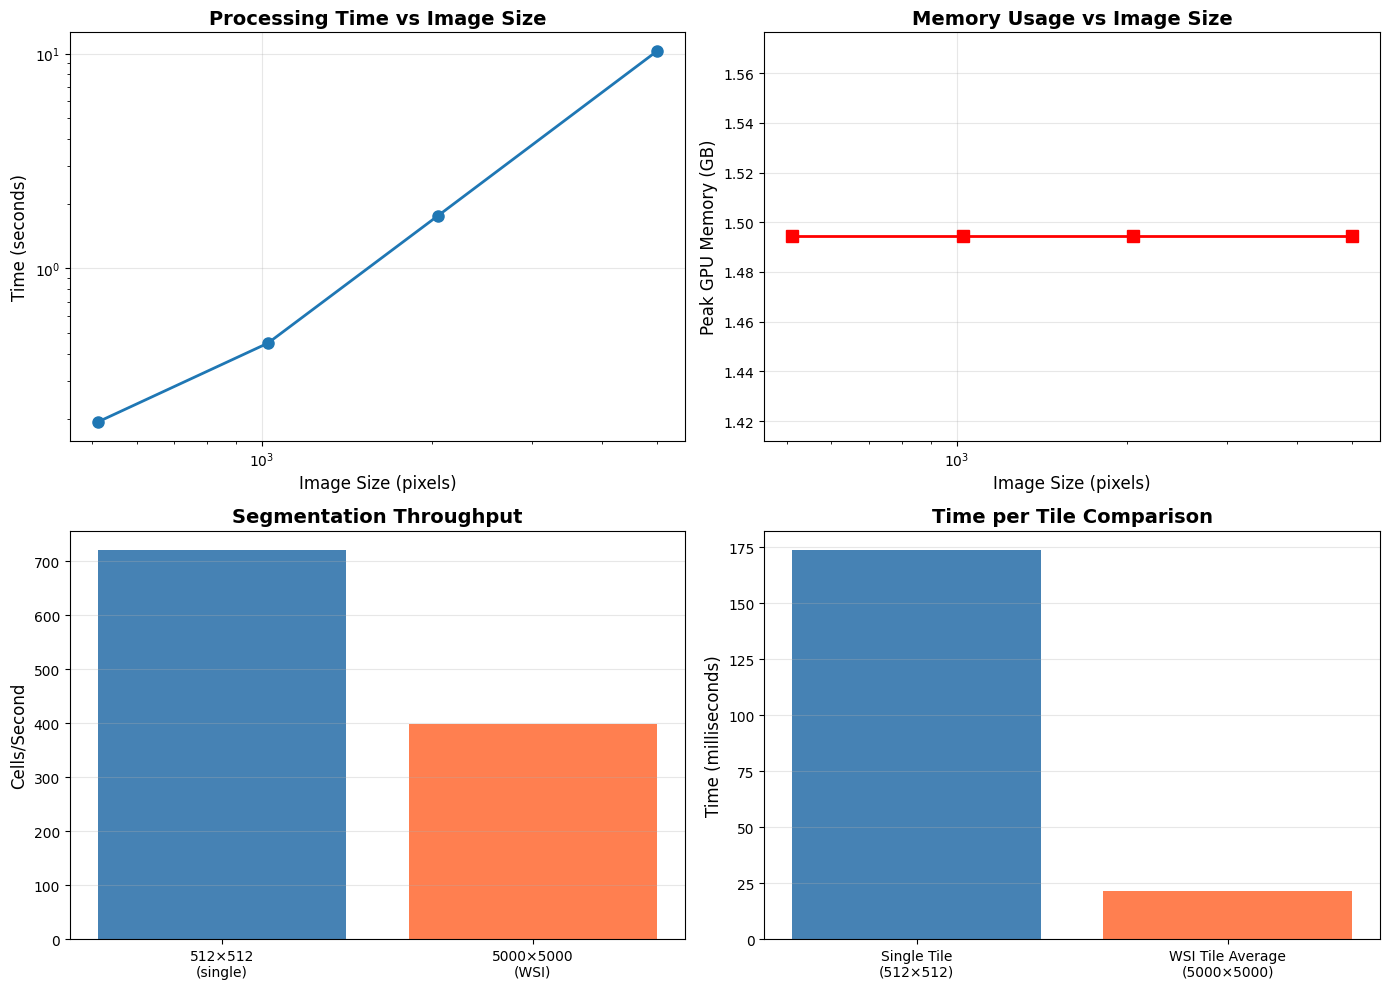


✓ Visualization saved to cellposesam_benchmark_plots.png

BENCHMARK COMPLETE!

Key Metrics for Manuscript:
  • Time per 512×512 tile: 173.6 ms
  • Peak memory (single tile): 1.49 GB
  • WSI processing time (5000×5000): 0.17 minutes
  • Throughput: 398.9 cells/second
  • Tiles per minute: 2797.7


In [4]:
import numpy as np
import torch
import time
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from cellpose import models
import psutil
import gc

# ============================================
# METRIC EXTRACTION FUNCTIONS
# ============================================

def compute_segmentation_metrics(mask):
    """Compute detailed segmentation statistics"""
    unique_labels = np.unique(mask)
    n_cells = len(unique_labels) - 1  # exclude background (0)
    
    # Cell size statistics
    cell_sizes = []
    for label in unique_labels[1:]:  # skip background
        cell_sizes.append(np.sum(mask == label))
    
    return {
        'n_cells': n_cells,
        'mean_cell_size': np.mean(cell_sizes) if cell_sizes else 0,
        'median_cell_size': np.median(cell_sizes) if cell_sizes else 0,
        'std_cell_size': np.std(cell_sizes) if cell_sizes else 0,
        'min_cell_size': np.min(cell_sizes) if cell_sizes else 0,
        'max_cell_size': np.max(cell_sizes) if cell_sizes else 0,
    }

def measure_gpu_memory():
    """Measure current GPU memory usage"""
    if torch.cuda.is_available():
        return {
            'allocated_gb': torch.cuda.memory_allocated() / 1024**3,
            'reserved_gb': torch.cuda.memory_reserved() / 1024**3,
            'max_allocated_gb': torch.cuda.max_memory_allocated() / 1024**3,
        }
    return {'allocated_gb': 0, 'reserved_gb': 0, 'max_allocated_gb': 0}

def measure_cpu_memory():
    """Measure current CPU memory usage"""
    process = psutil.Process()
    return process.memory_info().rss / 1024**3  # GB

# ============================================
# LOAD MODEL
# ============================================

print("Loading Cellpose-SAM model...")
model = models.CellposeModel(gpu=True, pretrained_model='cpsam', device=torch.device('cuda'))
print("  ✓ Model loaded")

# ============================================
# 1. SINGLE TILE BENCHMARK (512×512)
# ============================================

print("="*70)
print("CELLPOSE-SAM BENCHMARK 1: SINGLE TILE (512×512)")
print("="*70)

# Load single tile
tile_512 = np.array(Image.open("test_images/ovarian-he_chunk_92.png"))
print(f"Tile shape: {tile_512.shape}")

# Reset memory stats
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
gc.collect()

# Warmup
print("Warmup runs...")
for _ in range(3):
    _ = model.eval(
        [tile_512],
        diameter=None,
        tile_overlap=0.1,
        augment=False,
        batch_size=8,
        normalize=True,
    )

# Benchmark
n_runs = 10
times_512 = []
memory_512 = []

print(f"Running {n_runs} timed iterations...")
for i in range(n_runs):
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
    
    start = time.time()
    mask_512, _, _ = model.eval(
        [tile_512],
        diameter=None,
        tile_overlap=0.1,
        augment=False,
        batch_size=8,
        normalize=True,
    )
    torch.cuda.synchronize()
    end = time.time()
    
    times_512.append(end - start)
    memory_512.append(measure_gpu_memory()['max_allocated_gb'])
    print(f"  Run {i+1}/{n_runs}: {times_512[-1]:.3f}s, {memory_512[-1]:.2f} GB")

mask_512 = mask_512[0]  # extract from list

# Compute segmentation metrics
seg_metrics_512 = compute_segmentation_metrics(mask_512)

results_512 = {
    'image_size': '512×512',
    'n_cells': seg_metrics_512['n_cells'],
    'mean_time_s': np.mean(times_512),
    'std_time_s': np.std(times_512),
    'median_time_s': np.median(times_512),
    'min_time_s': np.min(times_512),
    'max_time_s': np.max(times_512),
    'mean_time_ms': np.mean(times_512) * 1000,
    'peak_memory_gb': np.mean(memory_512),
    'cells_per_second': seg_metrics_512['n_cells'] / np.mean(times_512),
    'mean_cell_size_px': seg_metrics_512['mean_cell_size'],
    'median_cell_size_px': seg_metrics_512['median_cell_size'],
}

print("\nRESULTS:")
for key, value in results_512.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

# ============================================
# 2. WHOLE SLIDE IMAGE BENCHMARK (5000×5000)
# ============================================

print("\n" + "="*70)
print("CELLPOSE-SAM BENCHMARK 2: WHOLE SLIDE IMAGE (5000×5000)")
print("="*70)

# Load WSI
wsi_5000 = np.array(Image.open("test_images/region_5000x5000_standard.tif"))
print(f"WSI shape: {wsi_5000.shape}")

# Reset memory
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
gc.collect()

cpu_mem_before = measure_cpu_memory()
print(f"CPU memory before: {cpu_mem_before:.2f} GB")

# Cellpose-SAM tiles automatically when image > 256x256
# Using same tile_overlap=0.1 as default Cellpose-SAM inference (from paper methods)
start_wsi = time.time()
mask_wsi, _, _ = model.eval(
    [wsi_5000],
    diameter=None,
    tile_overlap=0.1,
    augment=False,
    batch_size=8,
    normalize=True,
)
torch.cuda.synchronize()
end_wsi = time.time()
elapsed_wsi = end_wsi - start_wsi

mask_wsi = mask_wsi[0]  # extract from list

cpu_mem_after = measure_cpu_memory()
gpu_mem_wsi = measure_gpu_memory()

# Compute segmentation metrics
seg_metrics_wsi = compute_segmentation_metrics(mask_wsi)

# Calculate tile statistics (Cellpose-SAM uses 256x256 tiles internally)
tile_size = 256
overlap_pixels = int(tile_size * 0.1)  # 0.1 overlap
stride = tile_size - overlap_pixels
n_tiles_x = int(np.ceil(wsi_5000.shape[1] / stride))
n_tiles_y = int(np.ceil(wsi_5000.shape[0] / stride))
total_tiles = n_tiles_x * n_tiles_y

results_wsi = {
    'image_size': '5000×5000',
    'n_tiles': total_tiles,
    'tile_size': '256×256',
    'overlap': overlap_pixels,
    'n_cells': seg_metrics_wsi['n_cells'],
    'total_time_s': elapsed_wsi,
    'total_time_min': elapsed_wsi / 60,
    'time_per_tile_s': elapsed_wsi / total_tiles,
    'time_per_tile_ms': (elapsed_wsi / total_tiles) * 1000,
    'peak_gpu_memory_gb': gpu_mem_wsi['max_allocated_gb'],
    'cpu_memory_delta_gb': cpu_mem_after - cpu_mem_before,
    'cells_per_second': seg_metrics_wsi['n_cells'] / elapsed_wsi,
    'tiles_per_minute': total_tiles / (elapsed_wsi / 60),
    'throughput_mpx_per_min': (5000 * 5000 / 1e6) / (elapsed_wsi / 60),
    'cell_density_per_mm2': seg_metrics_wsi['n_cells'] / ((5000 * 5000) / 1e6),
    'mean_cell_size_px': seg_metrics_wsi['mean_cell_size'],
}

print("\nRESULTS:")
for key, value in results_wsi.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

# ============================================
# 3. SCALING ANALYSIS: Different Image Sizes
# ============================================

print("\n" + "="*70)
print("CELLPOSE-SAM BENCHMARK 3: SCALING ANALYSIS")
print("="*70)

# Test different crops of the WSI
test_sizes = [512, 1024, 2048, 5000]
scaling_results = []

for size in test_sizes:
    print(f"\nTesting {size}×{size} image...")
    
    # Extract crop from center of WSI
    if size <= 5000:
        center_y, center_x = wsi_5000.shape[0]//2, wsi_5000.shape[1]//2
        y1, y2 = center_y - size//2, center_y + size//2
        x1, x2 = center_x - size//2, center_x + size//2
        test_img = wsi_5000[y1:y2, x1:x2]
    else:
        test_img = wsi_5000
    
    # Reset memory
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
    
    # Time the segmentation
    start = time.time()
    
    mask_test, _, _ = model.eval(
        [test_img],
        diameter=None,
        tile_overlap=0.1,
        augment=False,
        batch_size=8,
        normalize=True,
    )
    
    torch.cuda.synchronize()
    elapsed = time.time() - start
    
    mask_test = mask_test[0]  # extract from list
    
    mem = measure_gpu_memory()
    seg_metrics = compute_segmentation_metrics(mask_test)
    
    scaling_results.append({
        'size': size,
        'n_pixels': size * size,
        'n_cells': seg_metrics['n_cells'],
        'time_s': elapsed,
        'time_ms': elapsed * 1000,
        'memory_gb': mem['max_allocated_gb'],
        'cells_per_sec': seg_metrics['n_cells'] / elapsed,
        'pixels_per_sec': (size * size) / elapsed,
    })
    
    print(f"  Time: {elapsed:.2f}s, Cells: {seg_metrics['n_cells']}, Memory: {mem['max_allocated_gb']:.2f} GB")

# ============================================
# 4. COMPILE ALL RESULTS
# ============================================

print("\n" + "="*70)
print("CELLPOSE-SAM COMPREHENSIVE BENCHMARK SUMMARY")
print("="*70)

# Create summary dataframe
summary_df = pd.DataFrame([
    {
        'Test': 'Single Tile (512×512)',
        'Size': '512×512',
        'Cells': results_512['n_cells'],
        'Time (s)': results_512['mean_time_s'],
        'Time (ms)': results_512['mean_time_ms'],
        'Memory (GB)': results_512['peak_memory_gb'],
        'Cells/sec': results_512['cells_per_second'],
    },
    {
        'Test': 'WSI (5000×5000)',
        'Size': '5000×5000',
        'Cells': results_wsi['n_cells'],
        'Time (s)': results_wsi['total_time_s'],
        'Time (ms)': results_wsi['time_per_tile_ms'],
        'Memory (GB)': results_wsi['peak_gpu_memory_gb'],
        'Cells/sec': results_wsi['cells_per_second'],
    }
])

print("\n" + summary_df.to_string(index=False))

# Create scaling dataframe
scaling_df = pd.DataFrame(scaling_results)
print("\n" + "="*70)
print("SCALING ANALYSIS")
print("="*70)
print(scaling_df.to_string(index=False))

# ============================================
# 5. SAVE ALL RESULTS
# ============================================

# Save to CSV
summary_df.to_csv('cellposesam_benchmark_summary.csv', index=False)
scaling_df.to_csv('cellposesam_benchmark_scaling.csv', index=False)

# Save detailed results to JSON
import json

all_results = {
    'single_tile_512': results_512,
    'wsi_5000': results_wsi,
    'scaling': scaling_results,
    'hardware': {
        'gpu': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A',
        'gpu_memory_total_gb': torch.cuda.get_device_properties(0).total_memory / 1024**3 if torch.cuda.is_available() else 0,
    },
    'benchmark_date': time.strftime('%Y-%m-%d %H:%M:%S'),
}

with open('cellposesam_benchmark_complete.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print("\n✓ Results saved:")
print("  - cellposesam_benchmark_summary.csv")
print("  - cellposesam_benchmark_scaling.csv")
print("  - cellposesam_benchmark_complete.json")

# ============================================
# 6. VISUALIZATION
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Scaling - Time vs Image Size
axes[0, 0].plot(scaling_df['size'], scaling_df['time_s'], 'o-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Image Size (pixels)', fontsize=12)
axes[0, 0].set_ylabel('Time (seconds)', fontsize=12)
axes[0, 0].set_title('Processing Time vs Image Size', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')

# Plot 2: Scaling - Memory vs Image Size
axes[0, 1].plot(scaling_df['size'], scaling_df['memory_gb'], 's-', color='red', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Image Size (pixels)', fontsize=12)
axes[0, 1].set_ylabel('Peak GPU Memory (GB)', fontsize=12)
axes[0, 1].set_title('Memory Usage vs Image Size', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xscale('log')

# Plot 3: Throughput
axes[1, 0].bar(['512×512\n(single)', '5000×5000\n(WSI)'], 
               [results_512['cells_per_second'], results_wsi['cells_per_second']],
               color=['steelblue', 'coral'])
axes[1, 0].set_ylabel('Cells/Second', fontsize=12)
axes[1, 0].set_title('Segmentation Throughput', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Time breakdown
labels = ['Single Tile\n(512×512)', 'WSI Tile Average\n(5000×5000)']
times_ms = [results_512['mean_time_ms'], results_wsi['time_per_tile_ms']]
axes[1, 1].bar(labels, times_ms, color=['steelblue', 'coral'])
axes[1, 1].set_ylabel('Time (milliseconds)', fontsize=12)
axes[1, 1].set_title('Time per Tile Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('cellposesam_benchmark_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to cellposesam_benchmark_plots.png")

print("\n" + "="*70)
print("BENCHMARK COMPLETE!")
print("="*70)
print("\nKey Metrics for Manuscript:")
print(f"  • Time per 512×512 tile: {results_512['mean_time_ms']:.1f} ms")
print(f"  • Peak memory (single tile): {results_512['peak_memory_gb']:.2f} GB")
print(f"  • WSI processing time (5000×5000): {results_wsi['total_time_min']:.2f} minutes")
print(f"  • Throughput: {results_wsi['cells_per_second']:.1f} cells/second")
print(f"  • Tiles per minute: {results_wsi['tiles_per_minute']:.1f}")
print("="*70)

In [6]:
"""
Investigate how Cellpose-SAM draws final cell boundaries.
Fixed manual trace to match actual v4 API signatures.
"""

import numpy as np
import torch
from cellpose import models, dynamics
from skimage.draw import disk

# ──────────────────────────────────────────────
# 1. BUILD SYNTHETIC IMAGE (3 blobs)
# ──────────────────────────────────────────────
img = np.zeros((256, 256, 3), dtype=np.float32)
for cy, cx in [(80, 80), (80, 180), (180, 130)]:
    rr, cc = disk((cy, cx), 35, shape=img.shape[:2])
    img[rr, cc] = [1.0, 0.5, 0.3]

device = torch.device("cuda")
model = models.CellposeModel(gpu=True, model_type="cellpose-sam")

# ──────────────────────────────────────────────
# 2. GET RAW NETWORK OUTPUTS (no mask computation)
# ──────────────────────────────────────────────
masks_off, flows_off, _ = model.eval(img, diameter=70, compute_masks=False)

dP       = flows_off[1]   # (2, H, W) — predicted Y, X flow fields
cellprob = flows_off[2]   # (H, W)    — cell probability (raw logits)

print("=" * 70)
print("NETWORK RAW OUTPUTS")
print("=" * 70)
print(f"  dP shape        : {dP.shape}   (predicted Y, X flow fields)")
print(f"  cellprob shape  : {cellprob.shape}")
print(f"  cellprob range  : [{cellprob.min():.3f}, {cellprob.max():.3f}]")
print(f"  dP range        : [{dP.min():.3f}, {dP.max():.3f}]")

# ──────────────────────────────────────────────
# 3. STEP 1: threshold cellprob → get inds, then Euler-integrate flows
# ──────────────────────────────────────────────
cellprob_threshold = 0.0
print("\n" + "=" * 70)
print(f"STEP 1: cellprob thresholding (threshold={cellprob_threshold})")
print("=" * 70)

inds = np.nonzero(cellprob > cellprob_threshold)
print(f"  Pixels above threshold : {len(inds[0])}  of  {cellprob.size}")
print(f"  That's {100*len(inds[0])/cellprob.size:.1f}% of the image")

# This is exactly what compute_masks does before calling follow_flows:
#   dP * (cellprob > threshold) / 5.0
dP_masked = dP * (cellprob > cellprob_threshold) / 5.0

print("\n" + "=" * 70)
print(f"STEP 2: Euler integration — follow_flows(dP_masked, inds, niter=200)")
print("=" * 70)
print("  Each pixel iteratively steps by its flow vector for 200 iterations.")
print("  Pixels converge to fixed points = cell centers.")

p_final = dynamics.follow_flows(dP_masked, inds, niter=200, device=device)

if not torch.is_tensor(p_final):
    p_final_t = torch.from_numpy(p_final).to(device, dtype=torch.int)
else:
    p_final_t = p_final.int().to(device)

print(f"  p_final shape  : {p_final_t.shape}  (converged pixel locations)")
print(f"  p_final range  : [{p_final_t.min().item()}, {p_final_t.max().item()}]")

# Show how many unique convergence points exist (= raw cell centers)
# Stack the (Y, X) final positions for each participating pixel
coords = p_final_t[:, :].cpu().numpy()  # shape (2, N_active_pixels)
unique_endpoints = set(zip(coords[0].tolist(), coords[1].tolist()))
print(f"  Unique convergence points : {len(unique_endpoints)}")
print(f"  (These are the candidate cell centers before histogram filtering)")

# ──────────────────────────────────────────────
# 4. STEP 3: histogram binning + peak finding → labels
# ──────────────────────────────────────────────
print("\n" + "=" * 70)
print("STEP 3: get_masks_torch — histogram peaks → label assignment")
print("=" * 70)
print("  • Bins all converged positions into a 2D histogram")
print("  • max_pool with kernel=5 finds local maxima (peaks > 10 pixels)")
print("  • Each peak is grown outward (max_pool kernel=3, 5 iters) where hist > 2")
print("  • Every original pixel is labeled by which grown seed region it landed in")

mask_raw = dynamics.get_masks_torch(p_final_t, inds, dP.shape[1:],
                                     max_size_fraction=0.4)

unique_raw = np.unique(mask_raw)
print(f"  Raw mask labels          : {unique_raw}")
print(f"  Cells before flow filter : {len(unique_raw) - 1}")  # subtract background 0

# Per-cell pixel counts
for lbl in unique_raw[unique_raw > 0]:
    print(f"    Cell {lbl}: {(mask_raw == lbl).sum()} pixels")

# ──────────────────────────────────────────────
# 5. STEP 4: flow-error consistency filter
# ──────────────────────────────────────────────
print("\n" + "=" * 70)
print("STEP 4: remove_bad_flow_masks — flow consistency check")
print("=" * 70)
print("  • Recomputes flows FROM each predicted mask (diffusion from center)")
print("  • Compares to network-predicted flows via MSE")
print("  • Discards any mask with MSE > flow_threshold (0.4)")

mask_final = dynamics.remove_bad_flow_masks(mask_raw, dP,
                                             threshold=0.4, device=device)

unique_final = np.unique(mask_final)
print(f"  Final mask labels        : {unique_final}")
print(f"  Cells after flow filter  : {len(unique_final) - 1}")

# Per-cell counts after filter
for lbl in unique_final[unique_final > 0]:
    print(f"    Cell {lbl}: {(mask_final == lbl).sum()} pixels")

# ──────────────────────────────────────────────
# 6. VERIFY against full eval()
# ──────────────────────────────────────────────
print("\n" + "=" * 70)
print("VERIFICATION: compare to single eval() call")
print("=" * 70)
masks_check, _, _ = model.eval(img, diameter=70)
print(f"  Cells from eval()       : {len(np.unique(masks_check)) - 1}")
print(f"  Cells from manual trace : {len(unique_final) - 1}")
print(f"  Match: {len(np.unique(masks_check)) - 1 == len(unique_final) - 1}")

# ──────────────────────────────────────────────
# 7. SUMMARY
# ──────────────────────────────────────────────
print("\n" + "=" * 70)
print("SUMMARY: How Cellpose-SAM draws cell boundaries")
print("=" * 70)
print("""
  NO watershed. NO contour fitting. NO edge detection.

  The boundary method is IMPLICIT via learned flow-field dynamics:

  1. NETWORK predicts:
       • dP: per-pixel flow vectors (dY, dX) pointing toward cell centers
       • cellprob: per-pixel probability of being inside a cell

  2. MASKING + SCALING:
       • Zero out flows outside cellprob threshold
       • Divide flows by 5 (controls step size / convergence speed)

  3. EULER INTEGRATION (steps_interp):
       • Each active pixel follows its (dY, dX) vector for 200 steps
       • Pixels converge to fixed points = cell centers
       • Boundary pixels naturally split: they flow toward different centers

  4. HISTOGRAM PEAK DETECTION (get_masks_torch):
       • 2D histogram of all converged positions
       • Local maxima (peaks with >10 pixels, found via max_pool kernel=5)
         become seed points = cell centers
       • Seeds grown outward 5x via max_pool kernel=3 where hist > 2
       • Each original pixel labeled by which seed region it fell into

  5. FLOW-ERROR QUALITY FILTER:
       • For each mask: recompute expected flows via diffusion from center
       • Compare predicted vs expected flows (MSE)
       • Discard masks with MSE > 0.4 (inconsistent = bad segmentation)

  → Cell BOUNDARIES are the implicit convergence boundaries between
    neighboring flow basins. They are never explicitly computed as contours.
""")

model_type argument is not used in v4.0.1+. Ignoring this argument...


NETWORK RAW OUTPUTS
  dP shape        : (2, 256, 256)   (predicted Y, X flow fields)
  cellprob shape  : (256, 256)
  cellprob range  : [-11.140, 5.665]
  dP range        : [-4.983, 4.672]

STEP 1: cellprob thresholding (threshold=0.0)
  Pixels above threshold : 11584  of  65536
  That's 17.7% of the image

STEP 2: Euler integration — follow_flows(dP_masked, inds, niter=200)
  Each pixel iteratively steps by its flow vector for 200 iterations.
  Pixels converge to fixed points = cell centers.
  p_final shape  : torch.Size([2, 11584])  (converged pixel locations)
  p_final range  : [79, 180]
  Unique convergence points : 3
  (These are the candidate cell centers before histogram filtering)

STEP 3: get_masks_torch — histogram peaks → label assignment
  • Bins all converged positions into a 2D histogram
  • max_pool with kernel=5 finds local maxima (peaks > 10 pixels)
  • Each peak is grown outward (max_pool kernel=3, 5 iters) where hist > 2
  • Every original pixel is labeled by which g